In [ ]:
import numpy as np
import os
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import shutil
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    source = '/content/drive/MyDrive/AI6121/Assignment02 Disparity and Depth'
    destination = '/content'

    for sample_file in os.listdir(source):
        if sample_file.lower().endswith('jpg'):
            shutil.copyfile(os.path.join(source,sample_file), os.path.join(destination,sample_file)) 
    
    # cv2.imshow() will cause colab to crash so will need to use this instead
    from google.colab.patches import cv2_imshow
else:
    print("Please ensure the sample images are in the same folder as this notebook!")

Mounted at /content/drive


# Appearance based matching algorithm

In [ ]:
def compute_matching_cost(x1,x2, matching_cost_function = 'ssd'):
    
    if matching_cost_function == 'ssd':
        return np.sum(np.power(x1-x2,2))

    if matching_cost_function == 'ncc':
        # Normalised cross correlation as matching cost
        if np.sqrt(np.sum(np.power(x1-np.mean(x1),2)))*np.sqrt(np.sum(np.power(x2-np.mean(x2),2))) == 0:
            return 0
        else:

            return np.sum(np.multiply(x1-np.mean(x1),x2-np.mean(x2)))/(np.sqrt(np.sum(np.power(x1-np.mean(x1),2)))*np.sqrt(np.sum(np.power(x2-np.mean(x2),2))))

def appearance_based_matching(imgL, imgR, w=3, search_window = 20, matching_cost_function = 'ssd'):
    """
    1. Check if both images are same size and window_size is odd number
    2. Define an image patch size (w)
    3. Starting from the top left of the left image, select an image patch of size 'w' 
    4. Scan the right image horizontally for the best matching image patch
    5. The matching cost is computed using sum of squared difference between each pixel
    6. Calculate the disparity of the center pixel: horizontal distance between the left image's image patch & best matching image patch of the right image
    """
    assert imgL.shape == imgR.shape, f"left image has shape of:{imgL.shape} but right image has shape of:{imgR.shape}"
    assert w%2 == 1, f"window_size needs to be an odd number!"

    img_height, img_width, channel = imgL.shape
    disparity_map = np.zeros((img_height, img_width, channel)) # initialise an disparity map with zeros only
    half_w = int((w-1)/2) # 2 * half_w + 1 = w

    for yL in range(img_height):
        for xL in range(half_w,img_width-half_w):
            best_matching_cost = None # set matching cost as None
            img_patch_L = imgL[max(yL-half_w,0):min(yL+half_w+1,img_height),xL-half_w:xL+half_w+1,:]
            for xR in range(half_w,img_width-half_w):
                if abs(xL-xR) > search_window:
                    continue
                img_patch_R = imgR[max(yL-half_w,0):min(yL+half_w+1,img_height),xR-half_w:xR+half_w+1,:]

                matching_cost = compute_matching_cost(img_patch_L, img_patch_R, matching_cost_function=matching_cost_function)

                if best_matching_cost is None:
                    best_matching_cost = matching_cost
                    best_xR = xR
                elif matching_cost <= best_matching_cost and abs(xL-xR) < abs(xL-best_xR):
                    best_matching_cost = matching_cost
                    best_xR = xR
                elif matching_cost < best_matching_cost:
                    best_matching_cost = matching_cost
                    best_xR = xR
                else:
                    continue

            disparity_map[yL,xL,:] = abs(best_xR-xL)

    return disparity_map

def transform_pixel(channel):
    hist,bins = np.histogram(channel.flatten(),256,[0,256])
    cdf = hist.cumsum()

    cdf_m = np.ma.masked_equal(cdf,0) # Hide the values that corresponds to pixel value that didnt exist in the image
    sk = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min()) # Scale the value from the current range to 0~255
    rounded_sk = np.rint(np.ma.filled(sk,0)) 
    return rounded_sk

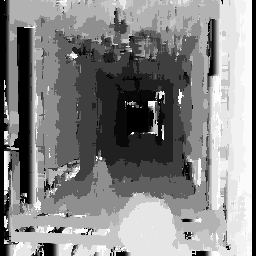

True

In [ ]:
img1 = cv.imread('corridorl.jpg')
img2 = cv.imread('corridorr.jpg')

window_size = 9
search_window = 15
disparity_map = appearance_based_matching(img1,img2,w=window_size,search_window=search_window)
corridor_disparity_map = transform_pixel(disparity_map.astype('uint8'))[disparity_map.astype('uint8')] # histogram equalisation to convert disparity value to pixel value

if IN_COLAB:
    cv2_imshow(corridor_disparity_map)
else:
    plt.imshow(corridor_disparity_map.astype('uint8'))

cv.imwrite('disparity_basis.png', disparity_map)

cv.imwrite('corridor_disparity_map.png', corridor_disparity_map)
cv.imwrite('hstacked_corridor.png',np.hstack((img1,img2,corridor_disparity_map)))

dst = cv.addWeighted(img1, 0.5, img2, 0.5, 0)
cv.imwrite('corridor_overlap.png',dst)
cv.imwrite('vstacked_corridor.png',np.vstack((dst,corridor_disparity_map)))

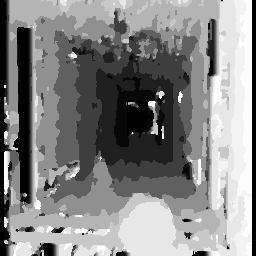

In [ ]:
#using median filter
blurred_disparity_map = cv.medianBlur(disparity_map.astype('uint8'),3)
if IN_COLAB:
    cv2_imshow(transform_pixel(blurred_disparity_map)[blurred_disparity_map])
else:
    plt.imshow((transform_pixel(blurred_disparity_map)[blurred_disparity_map]).astype('uint8'))

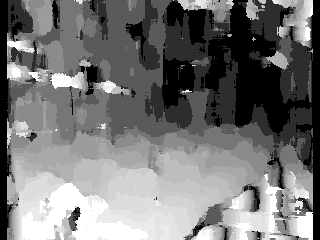

True

In [ ]:
img3 = cv.imread('triclopsi2l.jpg')
img4 = cv.imread('triclopsi2r.jpg')

window_size = 15
search_window = 15
disparity_map = appearance_based_matching(img3,img4,w=window_size,search_window=search_window)
triclopsi2_disparity_map = transform_pixel(disparity_map.astype('uint8'))[disparity_map.astype('uint8')] # histogram equalisation to convert disparity value to pixel value

if IN_COLAB:
    cv2_imshow(triclopsi2_disparity_map)
else:
    plt.imshow(triclopsi2_disparity_map.astype('uint8'))

cv.imwrite('triclopsi2_disparity_map.png', triclopsi2_disparity_map)
cv.imwrite('hstacked_triclopsi2.png',np.hstack((img3,img4,triclopsi2_disparity_map)))

dst = cv.addWeighted(img3, 0.5, img4, 0.5, 0)
cv.imwrite('triclopsi2_overlap.png',dst)
cv.imwrite('vstacked_triclopsi2.png',np.vstack((dst,triclopsi2_disparity_map)))

# Semi-Global Matching (SGM) with Census Values and Hemming Distance

In [ ]:
import argparse
import sys
import time as t

import cv2
import numpy as np
from matplotlib import cm
from PIL import Image
from IPython.display import display

In [ ]:
img1 = cv.imread('corridorl.jpg',cv.IMREAD_GRAYSCALE)
img2 = cv.imread('corridorr.jpg',cv.IMREAD_GRAYSCALE)

img3 = cv.imread('triclopsi2l.jpg',cv.IMREAD_GRAYSCALE)
img4 = cv.imread('triclopsi2r.jpg',cv.IMREAD_GRAYSCALE)

In [ ]:
max_disparity = 17 # maximum disparity for the stereo pair
P1 = 16 # penalty for disparity difference = 1
P2 = 120 # penalty for disparity difference > 1
csize = (5, 5) # size of the kernel for the census transform.
bsize = (3, 3) # size of the kernel for blurring the images and median filtering.

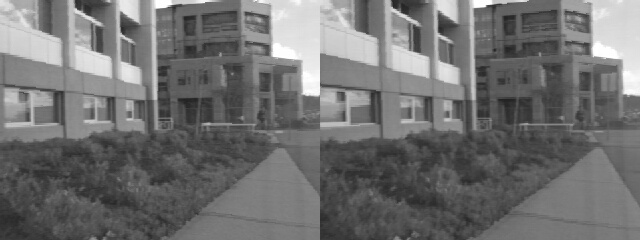

In [ ]:
left = img3
right = img4

height = left.shape[0]
width = left.shape[1]
assert left.shape[0] == right.shape[0] and left.shape[1] == right.shape[1], 'left & right must have the same shape.'
assert max_disparity > 0, 'maximum disparity must be greater than 0.'

joined_gray = np.concatenate([left, right], axis=1)
display(Image.fromarray(joined_gray))

## Smoothing the images

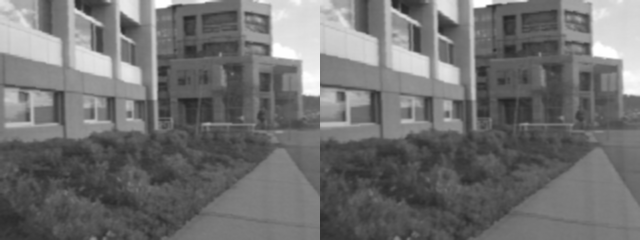

In [ ]:
left = cv2.GaussianBlur(left, bsize, 0, 0)
right = cv2.GaussianBlur(right, bsize, 0, 0)

joined_smoothed = np.concatenate([left, right], axis=1)
display(Image.fromarray(joined_smoothed))

## Cencus value computation

In [ ]:
def compute_census(left, right, csize, height, width):
    """
    Calculate census bit strings for each pixel in the left and right images.
    Arguments:
        - left: left grayscale image.
        - right: right grayscale image.
        - csize: kernel size for the census transform.
        - height: number of rows of the image.
        - width: number of columns of the image.

    Return: Left and right images with pixel intensities replaced with census bit strings.
    """
    cheight = csize[0]
    cwidth = csize[1]
    y_offset = int(cheight / 2)
    x_offset = int(cwidth / 2)

    left_census_values = np.zeros(shape=(height, width), dtype=np.uint64)
    right_census_values = np.zeros(shape=(height, width), dtype=np.uint64)

    print('\tComputing left and right census...', end='')
    sys.stdout.flush()
    dawn = t.time()
    # offset is used since pixels on the border will have no census values
    for y in range(y_offset, height - y_offset):
        for x in range(x_offset, width - x_offset):
            # left
            center_pixel = left[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = left[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            left_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            left_census_pixel = np.int32(left_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            left_census_values[y, x] = left_census_pixel

            # right
            center_pixel = right[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = right[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            right_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            right_census_pixel = np.int32(right_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            right_census_values[y, x] = right_census_pixel

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_census_values, right_census_values

In [ ]:
left_census, right_census = compute_census(left, right, csize, height, width)

	Computing left and right census...	(done in 2.78s)


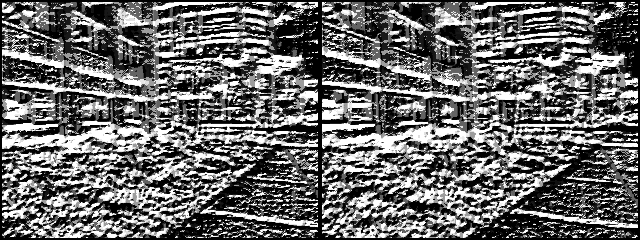

In [ ]:
joined_census = np.concatenate([np.uint8(left_census), np.uint8(right_census)], axis=1)
display(Image.fromarray(joined_census))

In [ ]:
def compute_costs(left_census_values, right_census_values, max_disparity, csize, height, width):
    """
    Create cost volume for all potential disparities. 
    Cost volumes for both left and right images are calculated.
    Hamming distance is used to calculate the matching cost between 
    two pixels census values.
    Arguments:
        - left_census_values: left image containing census bit strings for each pixel (in integer form).
        - right_census_values: right image containing census bit strings for each pixel (in integer form).
        - max_disparity: maximum disparity to measure.
        - csize: kernel size for the census transform.
        - height: number of rows of the image.
        - width: number of columns of the image.

    Return: Left and right cost volumes with dimensions H x W x D.
    """
    cwidth = csize[1]
    x_offset = int(cwidth / 2)

    print('\tComputing cost volumes...', end='')
    sys.stdout.flush()
    dawn = t.time()
    left_cost_volume = np.zeros(shape=(height, width, max_disparity), dtype=np.uint32)
    right_cost_volume = np.zeros(shape=(height, width, max_disparity), dtype=np.uint32)
    lcensus = np.zeros(shape=(height, width), dtype=np.int32)
    rcensus = np.zeros(shape=(height, width), dtype=np.int32)

    for d in range(0, max_disparity):
        # The right image is shifted d pixels accross
        rcensus[:, (x_offset + d):(width - x_offset)] = right_census_values[:, x_offset:(width - d - x_offset)]
        # 1 is assigned when the bits differ and 0 when they are the same
        left_xor = np.int32(np.bitwise_xor(np.int32(left_census_values), rcensus))
        # All the 1's are summed up to give us the number of different pixels (the cost)
        left_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(left_xor == 0):
            tmp = left_xor - 1
            mask = left_xor != 0
            left_xor[mask] = np.bitwise_and(left_xor[mask], tmp[mask])
            left_distance[mask] = left_distance[mask] + 1
        # All the costs for that disparity are added to the cost volume
        left_cost_volume[:, :, d] = left_distance

        # The left image is shifted d pixels accross
        lcensus[:, x_offset:(width - d - x_offset)] = left_census_values[:, (x_offset + d):(width - x_offset)]
        # 1 is assigned when the bits differ and 0 when they are the same
        right_xor = np.int32(np.bitwise_xor(np.int32(right_census_values), lcensus))
        # All the 1's are summed up to give us the number of different pixels (the cost)
        right_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(right_xor == 0):
            tmp = right_xor - 1
            mask = right_xor != 0
            right_xor[mask] = np.bitwise_and(right_xor[mask], tmp[mask])
            right_distance[mask] = right_distance[mask] + 1
        # All the costs for that disparity are added to the cost volume
        right_cost_volume[:, :, d] = right_distance

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_cost_volume, right_cost_volume

In [ ]:
left_cost_volume, right_cost_volume = compute_costs(left_census, right_census, max_disparity, csize, height, width)

	Computing cost volumes...	(done in 1.05s)


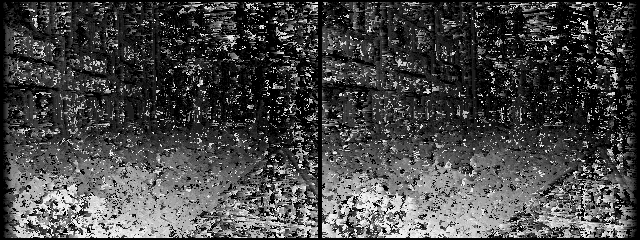

In [ ]:
def normalize(disp, max_disparity):
    """
    Normalizes the disparity map, then
    quantizes it so that it can be displayed. 
    Arguments:
        - disp: disparity map with dimensions H x W.
        - max_disparity: maximum disparity of the array.
    
    Return: normalized then quantized array, ready for visualization.
    """
    return 255.0 * disp / max_disparity

left_costs = np.uint8(normalize(np.argmin(left_cost_volume, axis=2), max_disparity))
right_costs = np.uint8(normalize(np.argmin(right_cost_volume, axis=2), max_disparity))

joined_costs = np.concatenate([left_costs, right_costs], axis=1)
display(Image.fromarray(joined_costs))

In [ ]:
def get_penalties(max_disparity, P2, P1):
    """
    Creates a matrix of all the potential penalties for matching
    a current disparity (represented by the column index), with 
    a previous disparity (represented by the row index).
    Arguments:
        - max_disparity: Maximum disparity of the array.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
    
    Return: Matrix containing all the penalties when disparity d1 from a column
            is matched with a previous disparity d2 from the row.
    """
    p2 = np.full(shape=(max_disparity, max_disparity), fill_value=P2, dtype=np.uint32)
    p1 = np.full(shape=(max_disparity, max_disparity), fill_value=P1 - P2, dtype=np.uint32)
    p1 = np.tril(p1, k=1) # keep values lower than k'th diagonal
    p1 = np.triu(p1, k=-1) # keep values higher than k'th diagonal
    no_penalty = np.identity(max_disparity, dtype=np.uint32) * -P1 # create diagonal matrix with values -p1
    penalties = p1 + p2 + no_penalty
    return penalties


def get_path_cost(slice, offset, penalties, other_dim, disparity_dim):
    """
    Calculates the minimum costs for all potential disparities of 
    the pixels along a single path direction.
    Arguments:
        - slice: Array containing costs for all disparities, D, 
            along a direction, M, with dimension M x D
        - offset: Number of pixels on the border to ignore.
        - penalties: Matrix containing the penalties to assign to the 
            previous disparities costs. For previous disparities that differ 
            from current disparities. 
        - other_dim: Number of pixels in the current paths direction.
        - disparity_dim: Number of disparities to calculate minimum costs.

    Returns: The pixels minimum costs for all disparities, D, 
        along path direction, M, with shape M x D.
    """
    minimum_cost_path = np.zeros(shape=(other_dim, disparity_dim), dtype=np.uint32)
    minimum_cost_path[offset - 1, :] = slice[offset - 1, :]

    for pixel_index in range(offset, other_dim):
        # Get all the minimum disparities costs from the previous pixel in the path
        previous_cost = minimum_cost_path[pixel_index - 1, :]
        # Get all the disparities costs (from the cost volume) for the current pixel
        current_cost = slice[pixel_index, :]
        costs = np.repeat(previous_cost, repeats=disparity_dim, axis=0).reshape(disparity_dim, disparity_dim)
        # Add penalties to the previous pixels disparities that differ from current pixels disparities
        costs = costs + penalties
        # Find minimum costs for the current pixels disparities using the previous disparities costs + penalties 
        costs = np.amin(costs, axis=0)  
        # Current pixels disparities costs + minimum previous pixel disparities costs (with penalty) - 
        # (constant term) minimum previous cost from all disparities 
        pixel_direction_costs = current_cost + costs - np.amin(previous_cost)
        minimum_cost_path[pixel_index, :] = pixel_direction_costs

    return minimum_cost_path    


def aggregate_costs(cost_volume, P2, P1, height, width, disparities):
    """
    Calculates the pixels costs for all disparities along all paths (4 in this case).

    Arguments: 
        - cost_volume: Array containing the matching cost for each pixel at each disparity.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
        - height: Number of rows of the image.
        - width: Number of columns of the image.
        - disparities: Number of disparities to calculate minimum matching costs.

    Returns: Array containing the pixels matching costs for all disparities along 
        all directions, with dimension H x W x D X 4.
    """
    sys.stdout.flush()
    dawn = t.time()

    penalties = get_penalties(disparities, P2, P1)

    print("\tProcessing North and South aggregation...")
    south_aggregation = np.zeros(shape=(height, width, disparities), dtype=np.uint32)
    north_aggregation = np.copy(south_aggregation)

    for x in range(0, width):
        # Takes all the rows and disparities for a single column
        south = cost_volume[:, x, :]
        # Invert the rows to get the opposite direction
        north = np.flip(south, axis=0)
        south_aggregation[:, x, :] = get_path_cost(south, 1, penalties, height, disparities)
        north_aggregation[:, x, :] = np.flip(get_path_cost(north, 1, penalties, height, disparities), axis=0)


    print("\tProcessing East and West aggregation...", end='')
    east_aggregation = np.copy(south_aggregation)
    west_aggregation = np.copy(south_aggregation)
    for y in range(0, height):
        # Takes all the column and disparities for a single row
        east = cost_volume[y, :, :]
        # Invert the columns to get the opposite direction
        west = np.flip(east, axis=0)
        east_aggregation[y, :, :] = get_path_cost(east, 1, penalties, width, disparities)
        west_aggregation[y, :, :] = np.flip(get_path_cost(west, 1, penalties, width, disparities), axis=0)

    # Combine the costs from all paths into a single aggregation volume
    aggregation_volume = np.concatenate((south_aggregation[..., None], north_aggregation[..., None], east_aggregation[..., None], west_aggregation[..., None]), axis=3)

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return aggregation_volume

In [ ]:
get_penalties(max_disparity, P2, P1)

array([[  0,  16, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120],
       [ 16,   0,  16, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120],
       [120,  16,   0,  16, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120],
       [120, 120,  16,   0,  16, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120],
       [120, 120, 120,  16,   0,  16, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120],
       [120, 120, 120, 120,  16,   0,  16, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120],
       [120, 120, 120, 120, 120,  16,   0,  16, 120, 120, 120, 120, 120,
        120, 120, 120, 120],
       [120, 120, 120, 120, 120, 120,  16,   0,  16, 120, 120, 120, 120,
        120, 120, 120, 120],
       [120, 120, 120, 120, 120, 120, 120,  16,   0,  16, 120, 120, 120,
        120, 120, 120, 120],
       [120, 120, 120, 120, 120, 120, 120, 120,  16,   0,  16, 120, 120,
        1

In [ ]:
left_aggregation_volume = aggregate_costs(left_cost_volume, P2, P1, height, width, max_disparity)

	Processing North and South aggregation...
	Processing East and West aggregation...	(done in 6.95s)


In [ ]:
right_aggregation_volume = aggregate_costs(right_cost_volume, P2, P1, height, width, max_disparity)

	Processing North and South aggregation...
	Processing East and West aggregation...	(done in 7.00s)


# Disparity map display

In [ ]:
def select_disparity(aggregation_volume):
    """
    Converts the aggregation volume into a disparity map using 
    the winner takes all strategy. 
    Cost volume is first calculated by taking the sum of the costs over all paths.
    Then the disparities are determined by finding the 
    disparity index with the lowest cost for the pixel.

    Arguments:
        - aggregation_volume: Array containing the matching costs for 
            all pixels at all disparities and paths, with dimension H x W x D x N

    Returns: Disparity map with dimensions H x W.
    """
    # sum up costs for all directions
    volume = np.sum(aggregation_volume, axis=3) 
    # returns the disparity index with the minimum cost associated with each h x w pixel
    disparity_map = np.argmin(volume, axis=2) 
    return disparity_map

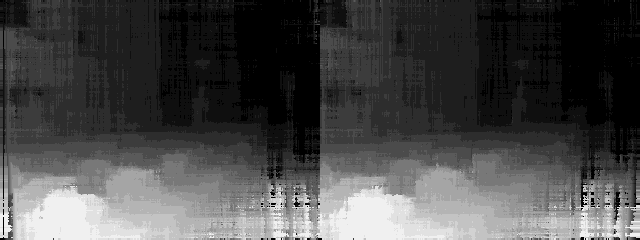

In [ ]:
left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), max_disparity))
right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), max_disparity))

joined_disparity_map = np.concatenate([left_disparity_map, right_disparity_map], axis=1)
display(Image.fromarray(joined_disparity_map))

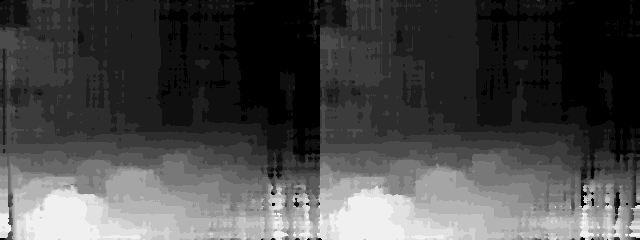

In [ ]:
left_disparity_map_smoothed = cv2.medianBlur(left_disparity_map, bsize[0])
right_disparity_map_smoothed = cv2.medianBlur(right_disparity_map, bsize[0])

joined_disparity_map_smoothed = np.concatenate([left_disparity_map_smoothed, right_disparity_map_smoothed], axis=1)
display(Image.fromarray(joined_disparity_map_smoothed))

In [ ]:
def create_depth_map(disp, cmap='jet'):
    """
    Converts single channel disparity map
    to an RGB depth map.
    Arguments:
      - disp: Quantized (uint8) disparity map with dimensions H x W 
      - cmap: a valid cmap named for use with matplotlib's 'get_cmap'
    
    Returns an RGB depth map with dimension H x W x 3.
    """
    color_map = cm.get_cmap(cmap)
    colors = color_map(np.arange(256))[:, :3].astype(np.float32)
    depth_map = np.take(colors, disp, axis=0)
    depth_map = np.uint8(depth_map * 255)
    return depth_map

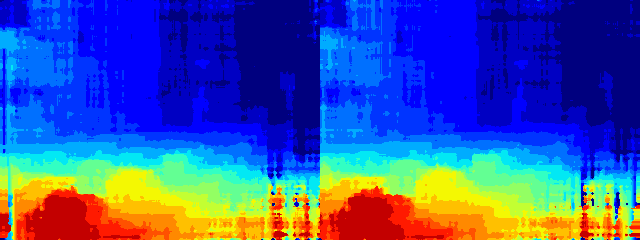

In [ ]:
left_depth_map = create_depth_map(left_disparity_map_smoothed)
right_depth_map = create_depth_map(right_disparity_map_smoothed)

joined_depth_map = np.concatenate([left_depth_map, right_depth_map], axis=1)
display(Image.fromarray(joined_depth_map))